# Chapter 3 - Building a weather station with TensorFlow Lite for Microcontrollers




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Python libraries

In [2]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

### Constants

In [3]:
BATCH_SIZE = 64
MELTING_TEMPERATURE = 2
MIN_SNOW_CM = 0.5 # Above this value, we consider it as snow
NUM_EPOCHS = 20
OUTPUT_DATASET_FILE = "snow_dataset.csv"
TFL_MODEL_FILE = "snow_forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "snow_forecast_model.h"
TF_MODEL = "snow_forecast"

**Importing weather data from WorldWeatherOnline**



---





## if wwo dosnt work use open meteo for data scraping

### Install the www-hist package

In [ ]:
!pip install wwo-hist

In [ ]:
pip install wwo-hist --upgrade

### Import retrieve_hist_data function from wwo-hist

In [ ]:
from wwo_hist import retrieve_hist_data # WorldWeatherOnline

### Acquire data for ten years (01-JAN-2011 to 31-DEC-2020) with an hourly frequency from Canazei

In [ ]:
frequency=1
api_key = 'ebb1061d03b04860a83213432242811'
location_list = ['canazei']

# retrieve_hist_data returns a list of dataframe(s)
df_weather = retrieve_hist_data(api_key,
                                location_list,
                                '01-JAN-2011',
                                '31-DEC-2020',
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)

### fetch data from open-Meteo

In [ ]:
pip install requests pandas


In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_weather_data(start_date, end_date, latitude, longitude):
    # Initialize an empty DataFrame
    all_data = pd.DataFrame()

    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    # Loop through each day (Open-Meteo supports daily queries for historical data)
    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")

        # Open-Meteo API URL for historical data
        url = (
            f"https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={latitude}&longitude={longitude}&start_date={date_str}"
            f"&end_date={date_str}&hourly=temperature_2m,relative_humidity_2m,snowfall"
        )

        # Fetch data from the API with a timeout
        try:
            response = requests.get(url, timeout=30)  # Setting a timeout of 30 seconds
            response.raise_for_status()  # Raise an exception for bad status codes
            data = response.json()
            if 'hourly' in data:
                # Create a DataFrame for hourly data
                df = pd.DataFrame(data['hourly'])
                df['datetime'] = pd.to_datetime(data['hourly']['time'])
                all_data = pd.concat([all_data, df], ignore_index=True)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {date_str}: {e}")

        # Increment the date by one day
        current_date += timedelta(days=1)

    # Reset index and return the DataFrame
    return all_data.reset_index(drop=True)

# Fetch data for Canazei (latitude: 46.4775, longitude: 11.7711)
latitude = 46.4775
longitude = 11.7711
start_date = "2011-12-15"
end_date = "2015-01-28"

# Call the function to fetch data
weather_data = fetch_weather_data(start_date, end_date, latitude, longitude)

# Save or display the data
weather_data.to_csv("canazei_weather_data.csv", index=False)
print(weather_data.head())

### Export temperature, humidity, and output snowfall to lists



In [ ]:
# Extract temperature, humidity and precipitation
t_list = weather_data['temperature_2m'].astype(float).to_list()
h_list = weather_data['relative_humidity_2m'].astype(float).to_list()
s_list = weather_data['snowfall'].astype(float).to_list()


print("Temperature List:", t_list)
print("Humidity List:", h_list)
print("Snowfall List:", s_list)

## Preparing the dataset

### Explore the extracted physical quantities in a 2D scatter chart

In [ ]:
def binarize(snow, threshold):
  if snow > threshold:
    return 1
  else:
    return 0

s_bin_list = [binarize(snow, 0.25) for snow in s_list]

cm = plt.cm.get_cmap('gray_r')
plt.figure(dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, label="Snow")
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

### Generate the output labels (Yes and No)

In [31]:
def gen_label(snow, temperature):
  if snow > 0.25 and temperature < 3:
    return "Yes"
  else:
    return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

### Build the dataset

In [32]:
csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)

### Balance the dataset by undersampling the majority class


In [ ]:
df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
  df0_sub = df0.sample(len(df1.index))
  df_dataset = pd.concat([df0_sub, df1])
else:
  df1_sub = df1.sample(len(df0.index))
  df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)

### Scale the input features with Z-score independently

here copy the mean and std in first run . because afte one run it will ouput mean 0 and std 1 because of df_dataset already been z score normalized. so t_list and h_list gonna change in 2nd run . it will cause probleb in upcoming code.


In [ ]:
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("at first run COPY ME!")  #here copy the mean and std in first run . because afte one run it will ouput mean 0 and std 1 because of df_dataset already been z score normalized.
print("Temperature - [MEAN, STD]  ",round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

# Scaling with Z-score function
def scaling(val, avg, std):
  return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))
display(df_dataset)

### Visualize raw/scaled input features distributions


<ipython-input-35-180eac70d47c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(t_list, ax=ax[0])
<ipython-input-35-180eac70d47c>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(h_list, ax=ax[1])
<ipython-input-35-180eac70d47c>:15: UserWarning: 

`distplot` is a deprecated function and will b

Text(0.5, 1.0, 'Normalized humidity')

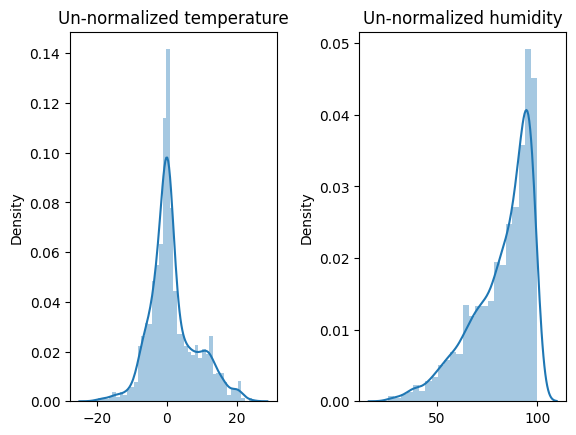

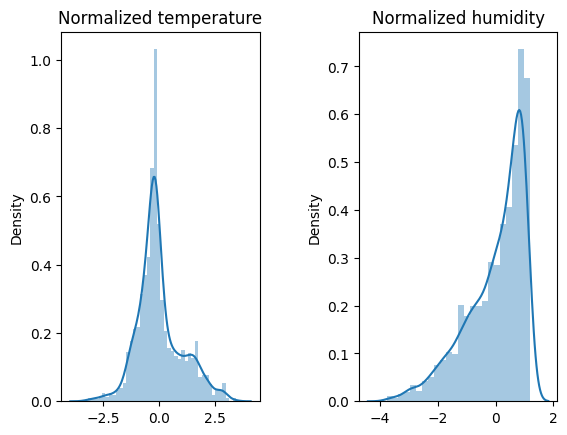

In [35]:
t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(t_list, ax=ax[0])
ax[0].set_title("Un-normalized temperature")
sns.distplot(h_list, ax=ax[1])
ax[1].set_title("Un-normalized humidity")

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
sns.distplot(t_norm_list, ax=ax[0])
ax[0].set_title("Normalized temperature")
sns.distplot(h_norm_list, ax=ax[1])
ax[1].set_title("Normalized humidity")

### Export to CSV file

In [37]:
df_dataset.to_csv(OUTPUT_DATASET_FILE, index=False)

## Training the ML model with TF

### Extract the input features and output labels from the df_dataset Pandas DataFrame

In [ ]:
f_names = df_dataset.columns.values[0:6]
l_name  = df_dataset.columns.values[6:7]
x = df_dataset[f_names]
y = df_dataset[l_name]

### Encode the labels to numerical values


In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit(y.Snow)
y_encoded = labelencoder.transform(y.Snow)

### Split the dataset into train, validation, and test datasets

In [ ]:
# Split 1 (85% vs 15%)
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
x_test, x_validate, y_test, y_validate = train_test_split(x_validate_test, y_validate_test, test_size=0.50, random_state = 3)

### Create the model with Keras API

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(len(f_names),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

### Compile the model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model

In [ ]:
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validate, y_validate))

### Analyze the accuracy and loss after each training epoch


In [ ]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)

def plot_train_val_history(x, y_train, y_val, type_txt):
  plt.figure(figsize = (10,7))
  plt.plot(x, y_train, 'g', label='Training'+type_txt)
  plt.plot(x, y_val, 'b', label='Validation'+type_txt)
  plt.title('Training and Validation'+type_txt)
  plt.xlabel('Epochs')
  plt.ylabel(type_txt)
  plt.legend()
  plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

### Save the entire TensorFlow model as a SavedModel

In [ ]:
model.save(TF_MODEL)

## Evaluating the model effectiveness

### Visualize the confusion matrix

In [ ]:
y_test_pred = model.predict(x_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.figure(figsize = (10,7))

### Calculate Recall, Precision, and F-score performance metrics

In [ ]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))


## Quantizing the model with TFLite converter

### Select a few hundred of samples randomly from the test dataset to calibrate the quantization

In [ ]:
def representative_data_gen():
  for i_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

### Import the TensorFlow SavedModel directory into TensorFlow Lite Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

### Initialize TensorFlow Lite converter for the 8-bit quantization

In [ ]:
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

### Convert the model to TensorFlow Lite file format (FlatBuffers) as save it as .tflite

In [ ]:
tflite_model_quant = converter.convert()
open(TFL_MODEL_FILE, "wb").write(tflite_model_quant)

### Convert the TensorFlow Lite model to C-byte array with xxd

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i snow_forecast_model.tflite > model.h
!cat model.h